<a href="https://colab.research.google.com/github/DJCordhose/ml-workshop/blob/master/notebooks/tf2/tf-keras-classifier-metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Metrics on binary classifications with TensorFlow 2

To generate models first run: https://colab.research.google.com/github/DJCordhose/ml-workshop/blob/master/notebooks/tf2/tf-keras-classifier.ipynb

In [0]:
import matplotlib.pyplot as plt
# plt.xkcd()
# plt.style.use('ggplot')
%matplotlib inline

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (20, 8)

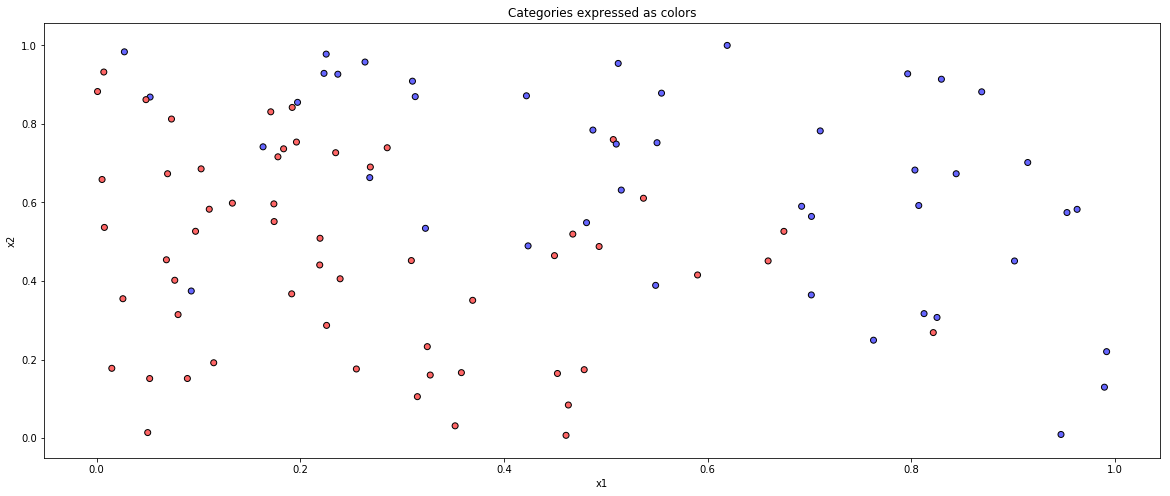

In [2]:
#@title Configure our example { display-mode: "form", run: "auto" }

# https://colab.research.google.com/notebooks/forms.ipynb

n = 100 #@param {type:"slider", min:1, max:1000, step:1}
m = -1 #@param {type:"slider", min:-10, max:10, step: 0.1}
b = 1 #@param {type:"slider", min:-10, max:10, step: 0.1}

noise_level = 0.2 #@param {type:"slider", min:0.0, max:1.0, step:0.1}

dim_1_label = 'x1' #@param {type:"string"}
dim_2_label = 'x2' #@param {type:"string"}

import numpy as np

# all points
X = np.random.uniform(0, 1, (n, 2))

# below or above line determines which category they belong to (plus noise)
noise = noise_level * np.random.normal(0, 1, n)
y = X[:, 1] > m*X[:, 0]+b + noise
y = y.astype(int)

from matplotlib.colors import ListedColormap

plt.xlabel(dim_1_label)
plt.ylabel(dim_2_label)
plt.title('Categories expressed as colors')

plt.scatter(X[:,0], X[:,1], c=y, cmap=ListedColormap(['#FF6666', '#6666FF']), marker='o', edgecolors='k');

## Load our two competing models

In [3]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
tf.__version__

TensorFlow 2.x selected.


'2.0.0-rc1'

In [4]:
x = tf.constant(X, dtype='float32')
y_true = tf.constant(y, dtype='float32')
x.shape, y.shape

(TensorShape([100, 2]), (100,))

In [5]:
!curl -O https://raw.githubusercontent.com/DJCordhose/ml-workshop/master/notebooks/tf2/linear-mse.h5
!curl -O https://raw.githubusercontent.com/DJCordhose/ml-workshop/master/notebooks/tf2/sigmoid-crossentropy.h5
!ls -l

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 14200  100 14200    0     0   149k      0 --:--:-- --:--:-- --:--:--  149k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 18488  100 18488    0     0   277k      0 --:--:-- --:--:-- --:--:--  277k
total 48
-rw-r--r-- 1 root root 14200 Sep 29 09:29 linear-mse.h5
drwxr-xr-x 1 root root  4096 Aug 27 16:17 sample_data
-rw-r--r-- 1 root root    15 Sep 29 09:05 sigmod-crossvalidation.h5
-rw-r--r-- 1 root root 18488 Sep 29 09:29 sigmoid-crossentropy.h5
-rw-r--r-- 1 root root    15 Sep 29 09:06 sigmoid-crossvalidation.h5


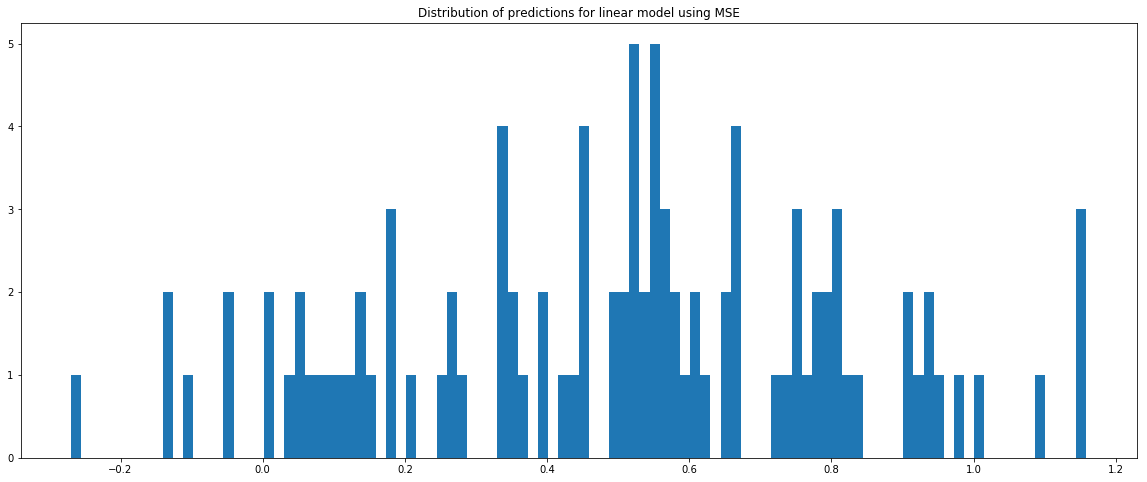

In [6]:
model_linear_mse = tf.keras.models.load_model('linear-mse.h5')

y_pred_model_linear_mse = model_linear_mse.predict(x)

plt.hist(y_pred_model_linear_mse, bins=n)
plt.title('Distribution of predictions for linear model using MSE');

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


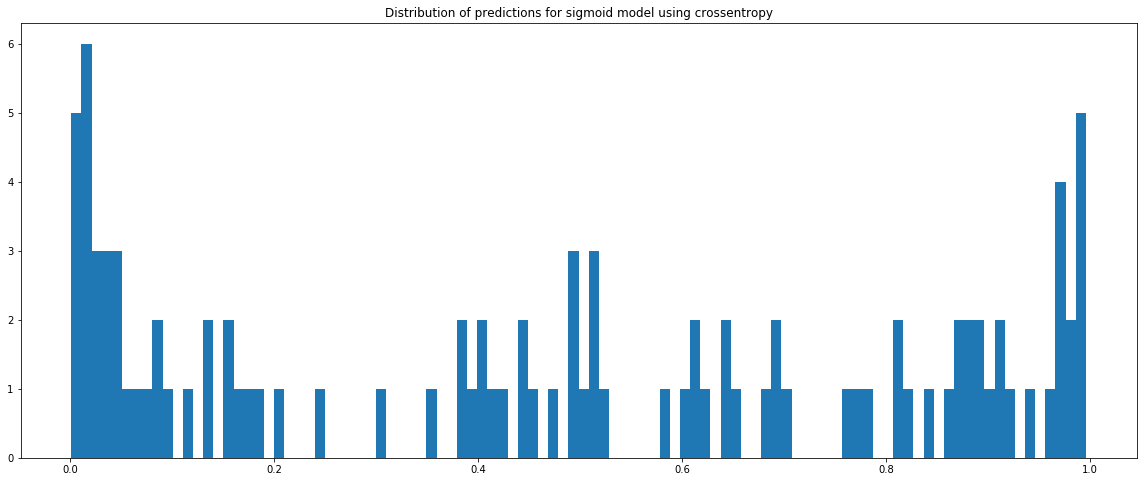

In [7]:
model_sigmoid_crossentropy = tf.keras.models.load_model('sigmoid-crossentropy.h5')

y_pred_model_sigmoid_crossentropy = model_sigmoid_crossentropy.predict(x)

plt.hist(y_pred_model_sigmoid_crossentropy, bins=n)
plt.title('Distribution of predictions for sigmoid model using crossentropy');

## Basic Metrics

* https://en.wikipedia.org/wiki/Precision_and_recall
* https://en.wikipedia.org/wiki/F1_score

### Most typical metrics

* _Precision_: ability not to label a sample as positive (1) that is negative (0)

* _Recall_: ability to find all the positive (1) samples

* _F1-Score_
  * harmonic mean of the precision and recall
  * harmonic mean is a good mean for ratios
  * best value at 1 and worstat 0

* _Support_: number of occurrences of samples for each class


In [0]:
# TensorFlow: https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/metrics
# Scikit-learn: https://scikit-learn.org/stable/modules/model_evaluation.html
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html

from sklearn.metrics import precision_recall_fscore_support

### Scores for linear model with MSE, higher is better

In [9]:
precision, recall, f1_score, support = precision_recall_fscore_support(y_true, (y_pred_model_linear_mse > 0.5).astype(int).reshape(-1))
precision, recall, f1_score, support

(array([0.8372093 , 0.64912281]),
 array([0.64285714, 0.84090909]),
 array([0.72727273, 0.73267327]),
 array([56, 44]))

### Scores for sigmode model with cross entropy, higher is better

In [10]:
precision, recall, f1_score, support = precision_recall_fscore_support(y_true, (y_pred_model_sigmoid_crossentropy > 0.5).astype(int).reshape(-1))
precision, recall, f1_score, support

(array([0.83018868, 0.74468085]),
 array([0.78571429, 0.79545455]),
 array([0.80733945, 0.76923077]),
 array([56, 44]))

## How would the scores change if we changed the threshold?

### ROC and AUC

_graphical plot which illustrates the performance of a binary classifier system as its discrimination threshold is varied_

_ROC curves typically feature true positive rate on the Y axis, and false positive rate on the X axis. This means that the top left corner of the plot is the “ideal” point - a false positive rate of zero, and a true positive rate of one. This is not very realistic, but it does mean that a larger area under the curve (AUC) is usually better._

* https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5
* https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc


In [11]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html
# https://scikit-learn.org/stable/modules/model_evaluation.html#roc-metrics

from sklearn.metrics import roc_curve, auc
# roc_curve?
fpr, tpr, thresholds = roc_curve(y_true, y_pred_model_linear_mse)
fpr, tpr, thresholds

(array([0.        , 0.        , 0.        , 0.01785714, 0.01785714,
        0.03571429, 0.03571429, 0.125     , 0.125     , 0.14285714,
        0.14285714, 0.19642857, 0.19642857, 0.26785714, 0.26785714,
        0.35714286, 0.35714286, 0.375     , 0.375     , 0.44642857,
        0.44642857, 0.75      , 0.75      , 1.        ]),
 array([0.        , 0.02272727, 0.43181818, 0.43181818, 0.61363636,
        0.61363636, 0.65909091, 0.65909091, 0.68181818, 0.68181818,
        0.70454545, 0.70454545, 0.77272727, 0.77272727, 0.84090909,
        0.84090909, 0.90909091, 0.90909091, 0.95454545, 0.95454545,
        0.97727273, 0.97727273, 1.        , 1.        ]),
 array([ 2.1577654 ,  1.1577654 ,  0.79209673,  0.7827214 ,  0.6691378 ,
         0.66899955,  0.6606398 ,  0.6045023 ,  0.5876593 ,  0.58415365,
         0.573387  ,  0.5603845 ,  0.55619264,  0.5328444 ,  0.52125657,
         0.50083804,  0.45735466,  0.45173573,  0.43215883,  0.3635757 ,
         0.34893918,  0.1214239 ,  0.11532572, -

In [12]:
roc_auc = auc(fpr, tpr)
roc_auc

0.8887987012987013

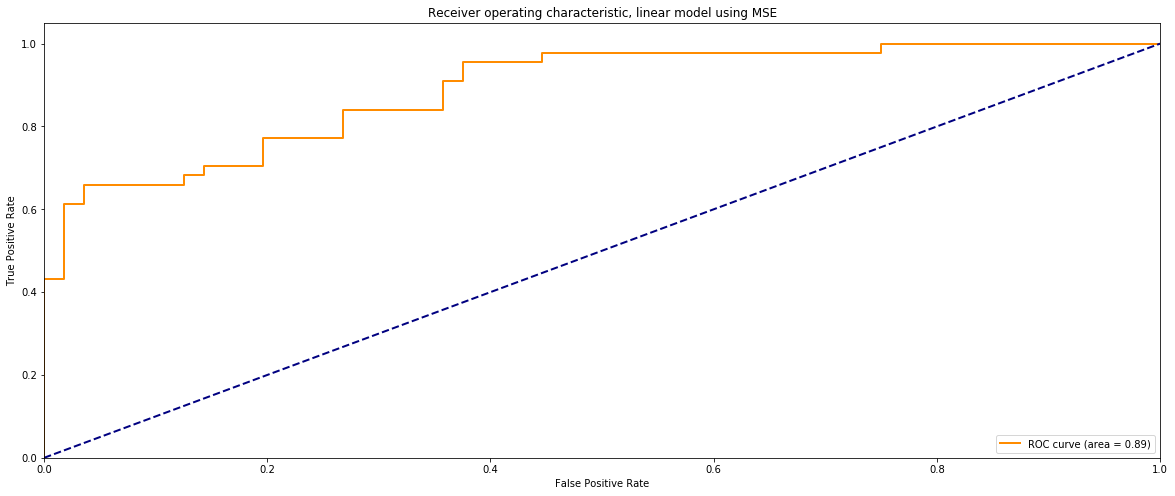

In [13]:
# code more or less taken from
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic, linear model using MSE')
plt.legend(loc="lower right");

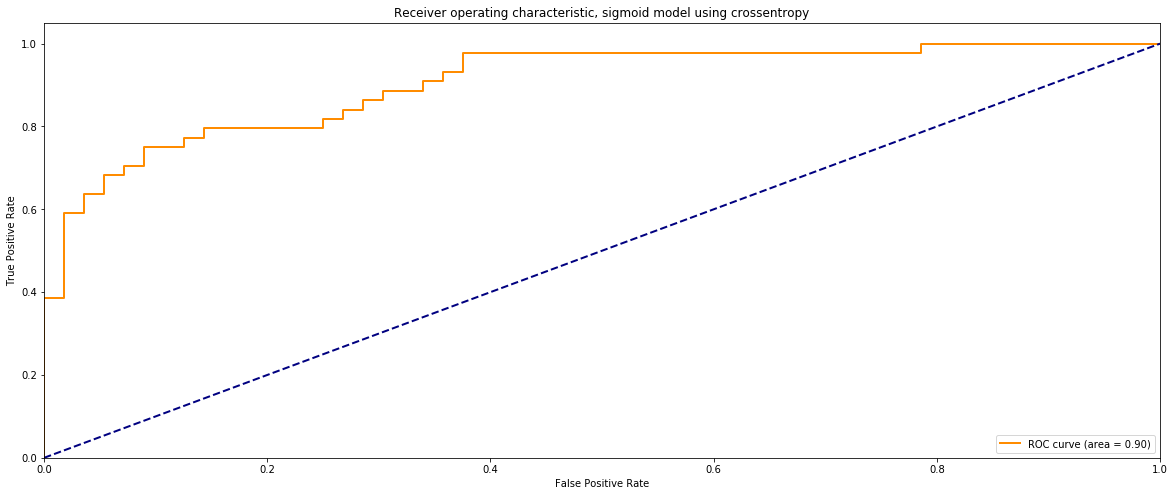

In [14]:
fpr, tpr, thresholds = roc_curve(y_true, y_pred_model_sigmoid_crossentropy)
roc_auc = auc(fpr, tpr)

lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic, sigmoid model using crossentropy')
plt.legend(loc="lower right");